<a href="https://colab.research.google.com/github/tigerjk726/Bumjoong/blob/main/Typhoon_modeling_Korea_20221208_7~10_Ver_07(frequency).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT DATA

In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')             

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/2022.10.10 typhoon

/content/drive/My Drive/Colab Notebooks/2022.10.10 typhoon


In [ ]:
import pandas as pd
df = pd.read_csv('19592021korea(2).csv')
df

칼럼별 명칭

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
df.columns

Index(['year', 'mon', 'amo', 'aao', 'ao', 'emi', 'gmo', 'nino3', 'nino4',
       'pdo', 'pna', 'qbo', 'freq', 'inten'],
      dtype='object')

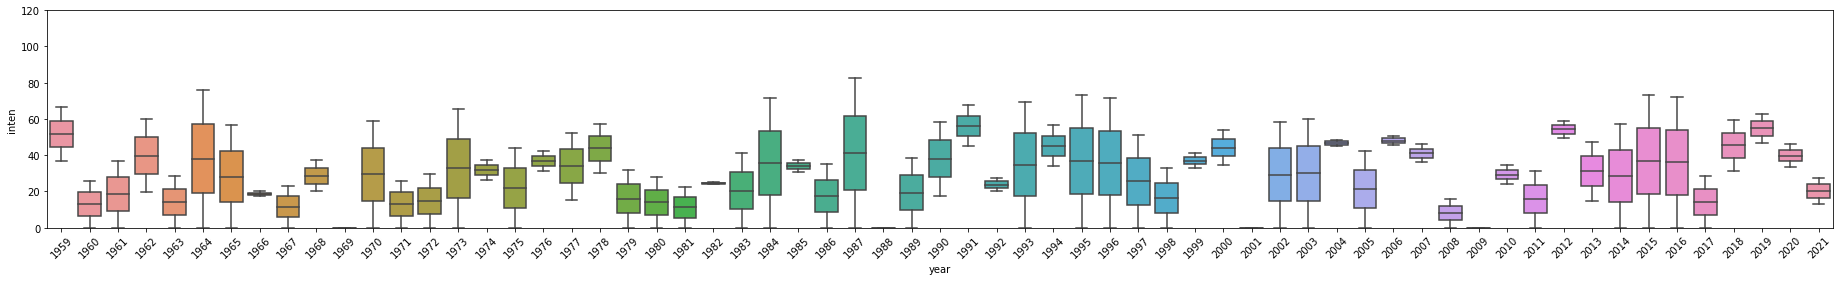

In [ ]:
var = 'year'
data = pd.concat([df['inten'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(32, 4))
fig = sns.boxplot(x=var, y="inten", data=data)
fig.axis(ymin=0, ymax=120);
plt.xticks(rotation=45);

# Data Splitting


In [ ]:
df1 = df[df["mon"].isin([78])]
df2 = df[df["mon"].isin([910])]

In [ ]:
#train = df[df["year"].isin(list(range(1959,2019,1)))]

In [ ]:
#test = df[df["year"].isin(list(range(2019,2021,1)))]

In [ ]:
x = df1.iloc[:,2:12]
y1 = df1.iloc[:,12:13]
y2 = df1.iloc[:,13:]
print(y1, y2,np.mean(y1), np.mean(y2))

     freq
0       2
2       2
4       2
6       2
8       1
..    ...
116     1
118     4
120     3
122     2
124     1

[63 rows x 1 columns]      inten
0     66.5
2     26.0
4     37.0
6     60.0
8     28.5
..     ...
116   28.5
118   59.5
120   47.0
122   33.5
124   13.0

[63 rows x 1 columns] freq    1.888889
dtype: float64 inten    37.587302
dtype: float64


In [ ]:
X = df2.iloc[:,2:12]
Y1 = df2.iloc[:,12:13]
Y2 = df2.iloc[:,13:]
print(Y1, Y2, np.mean(Y1), np.mean(Y2))

     freq
1       2
3       0
5       0
7       1
9       0
..    ...
117     0
119     1
121     3
123     2
125     1

[63 rows x 1 columns]      inten
1     37.0
3      0.0
5      0.0
7     19.5
9      0.0
..     ...
117    0.0
119   31.5
121   62.5
123   46.0
125   27.5

[63 rows x 1 columns] freq    0.634921
dtype: float64 inten    18.920635
dtype: float64


#Modelling


In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Elastic Net Regression :
again made robust to outliers

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

## LASSO Regression :
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

## Kernel Ridge Regression :


In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)


## Gradient Boosting Regression :
With huber loss that makes it robust to outliers

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

## XGBoost :

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

## LightGBM :

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

# Scores : Base model

In [ ]:
#Validation function

def rmsle_cv_f(model):
    cv = LeaveOneOut()
    rmse = -cross_val_score(model, x, y1, scoring="neg_mean_squared_error", cv = cv)
    return(rmse)

def rmsle_cv_i(model):
    cv = LeaveOneOut()
    rmse = -cross_val_score(model, x, y2, scoring="neg_mean_squared_error", cv = cv)
    return(rmse)

def rmsle_cv_f2(model):
    cv = LeaveOneOut()
    rmse = -cross_val_score(model, X, Y1, scoring="neg_mean_squared_error", cv = cv)
    return(rmse)    

def rmsle_cv_i2(model):
    cv = LeaveOneOut()
    rmse = -cross_val_score(model, X, Y2, scoring="neg_mean_squared_error", cv = cv)
    return(rmse)    



In [ ]:
from statistics import mean

score_l = rmsle_cv_f(lasso)
print("score: {:.4f}\n".format(mean(abs(score_l))))

score2_l = rmsle_cv_f2(lasso)
print("score2: {:.4f}\n".format(mean(abs(score2_l))))

score: 1.9352

score2: 0.5438



In [ ]:
score_e = rmsle_cv_f(ENet)
print("score: {:.4f}\n".format(mean(abs(score_e))))

score2_e = rmsle_cv_f2(ENet)
print("score2: {:.4f}\n".format(mean(abs(score2_e))))

score: 1.9349

score2: 0.5439



In [ ]:
score_x = rmsle_cv_f(model_xgb)
print("score_x: {:.4f}\n".format(mean(abs(score_x))))

score2_x = rmsle_cv_f2(model_xgb)
print("score2_x: {:.4f}\n".format(mean(abs(score2_x))))

score_x: 2.3151

score2_x: 0.5037



In [ ]:
score_g = rmsle_cv_f(model_lgb)
print("score_g: {:.4f}\n".format(mean(abs(score_g))))

score2_g = rmsle_cv_f2(model_lgb)
print("score2_g: {:.4f}\n".format(mean(abs(score2_g))))

score_g: 2.6959

score2_g: 0.5718



In [ ]:
score_l

array([6.38542225e-02, 1.40507146e-04, 9.35932465e-01, 1.15708145e-01,
       2.33754193e+00, 1.99694018e+00, 1.25762528e+00, 7.09239458e-01,
       4.60651548e+00, 2.08591186e-04, 6.58224542e+00, 4.29404464e+00,
       8.83417034e-01, 3.79561118e-01, 2.16462333e-01, 8.93560306e-01,
       3.16954055e-01, 3.57873500e+00, 4.54227771e-01, 3.33815743e-02,
       7.01415107e-03, 3.22531649e+00, 7.24617990e-01, 5.75041385e-01,
       1.12395561e+00, 1.00104580e+00, 9.63759728e+00, 1.33125082e+00,
       1.83511467e-02, 3.09985357e+00, 2.02070490e+00, 9.84428190e-01,
       6.13393501e-03, 1.00012744e-01, 2.14654768e+00, 5.04969266e+00,
       2.28288283e+00, 2.63692160e-01, 2.20166606e+00, 1.01997788e-01,
       9.61368064e+00, 2.44898992e+00, 2.40274403e+00, 7.36205532e+00,
       5.31840903e+00, 1.17617274e-01, 1.60874533e+00, 2.49499730e-01,
       8.40693644e-02, 2.40020812e-01, 5.36846712e-01, 1.51977860e+00,
       1.12931076e-02, 1.09043628e+01, 1.66044185e+00, 1.66950512e+00,
      

In [ ]:
#df1["Name"] = df1["year"].apply(str) + ' ' + df1["mon"].apply(str)

In [ ]:
y1 = y1.set_index(df1["year"])

In [ ]:
score_l = pd.DataFrame(score_l)
score_l = score_l.set_index(df1["year"])

In [ ]:
df1["year"]

In [ ]:
# Y1 = Y1.values.tolist()

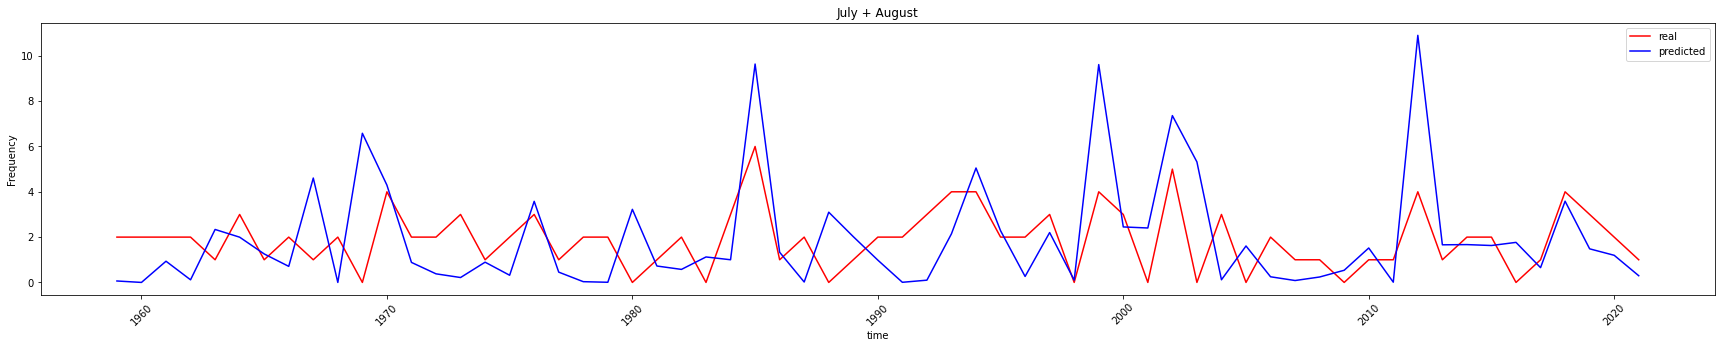

In [ ]:
plt.figure(figsize=(30, 5))  

plt.plot(y1, color='red', label='real')
plt.plot(score_l, color='blue', label='predicted')
plt.title('July + August')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
Corr = pd.merge(score_l, y1, on='Name')
Corr.corr()

,0,freq
0,1.000000,0.432321
freq,0.432321,1.000000


In [ ]:
#df2["Name"] = df2["year"].apply(str) + ' ' + df2["mon"].apply(str)

In [ ]:
Y1 = Y1.set_index(df2["year"])

In [ ]:
score2_x = pd.DataFrame(score2_x)
score2_x = score2_x.set_index(df2["year"])

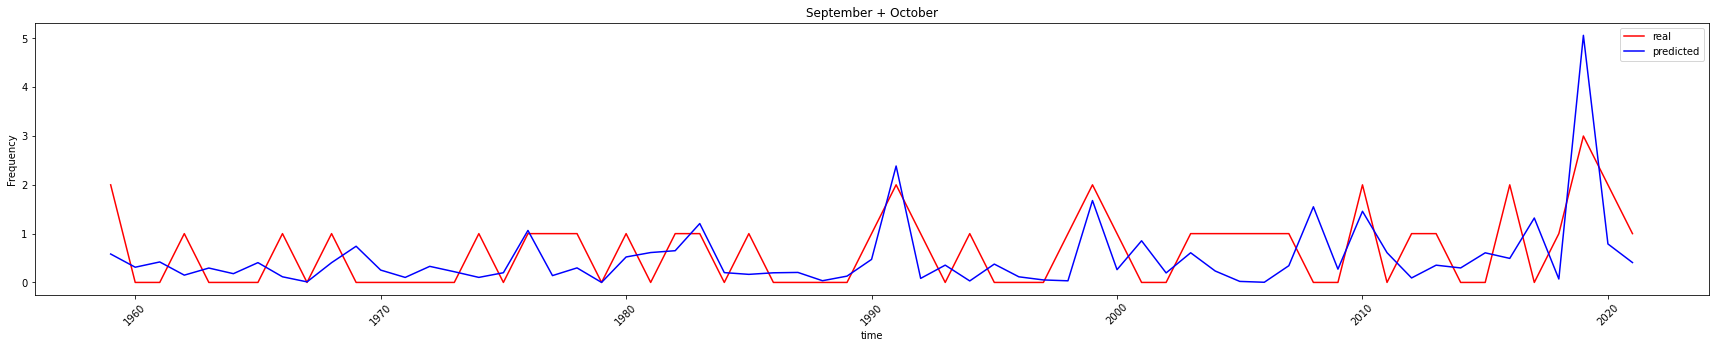

In [ ]:
plt.figure(figsize=(30, 5))  

plt.plot(Y1, color='red', label='real')
plt.plot(score2_x, color='blue', label='predicted')
plt.title('September + October')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
Corr = pd.merge(score2_x, Y1, on='year')
Corr.corr()

,0,freq
0,1.00000,0.52802
freq,0.52802,1.00000
